In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
from scipy.stats import norm
from astropy import modeling
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
#import ugradio
sbn.set_style('whitegrid')
sbn.axes_style()
plt.rc('font', family = 'serif')
import barycorrpy
import astropy.time
import time
import datetime
from matplotlib.patches import Rectangle

gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!


In [2]:
def _pack_prms(amp, avg, sig):
    '''Internal. Convert user arguments to parameter list.'''
    prms = np.array([amp, avg, sig])
    prms.shape = (3,-1)
    return prms.T.flatten()

def _unpack_prms(prms):
    '''Internal. Convert parameter list to user arguments.'''
    amp = np.array(prms[0::3]); amp.shape = (-1,1)
    avg = np.array(prms[1::3]); avg.shape = (-1,1)
    sig = np.array(prms[2::3]); sig.shape = (-1,1)
    return amp, avg, sig

def _gauss(x, *prms):
    '''Internal. Gaussian model that is fit to the data.'''
    amp, avg, sig = _unpack_prms(prms)
    ans = amp * np.exp(-(x-avg)**2/(2.*sig**2))
    return np.sum(amp * np.exp(-(x-avg)**2/(2.*sig**2)), axis=0)

def gaussfit(x, y, amp=1., avg=0., sig=1., return_cov=False):
    '''Fit amp, avg, and sig for a Gaussian [y = amp * e^(-(x-avg)^2/(2*sig^2)].
    amp/avg/sig can be lists/arrays to simultaneously fit multiple Gaussians.
    Parameters
    ----------
    x : x coordinate at which Gaussian is evaluated
    y : measured y coordinate to which Gaussian is compared
    amp : first guess at amp, the amplitude(s) of the Gaussian(s), default=1.
    avg : first guess at avg, the average(s) of the Gaussian(s), default=0.
    sig : first guess at sig, the width(s) of the Gaussian(s), default=1.
    return_cov : return the [amp, avg, sig] covariance matrix of the solution
    Returns
    -------
    ans : dictionary with amp/avg/sig keys and fit solutions as values.
    prm_covariance : the [amp, avg, sig] covariance matrix'''
    prms0 = _pack_prms(amp, avg, sig)
    prms, prm_covariance = curve_fit(_gauss, x, y, p0=prms0)
    amp, avg, sig = _unpack_prms(prms)
    ans = {'amp':amp.flatten(), 'avg':avg.flatten(), 'sig':sig.flatten()}
    if return_cov:
        return ans, prm_covariance
    else:
        return ans

def gaussval(x, amp, avg, sig):
    '''Evaluate a Gaussian given amp, avg, and sig [y = amp * e^(-(x-avg)^2/(2*sig^2)].
    amp/avg/sig can be lists/arrays to simultaneously fit multiple Gaussians.
    Parameters
    ----------
    x : x coordinate at which Gaussian is evaluated
    amp : amplitude(s) of Gaussian(s)
    avg : center point(s) of Gaussian(s)
    sig : width(s) of Gaussian(s)
    Returns
    -------
    y : the evaluated Gaussian [y = amp * e^(-(x-avg)^2/(2*sig^2)]'''
    prms = _pack_prms(amp, avg, sig)
    return _gauss(x, *prms)

def unix_time(jd=None):
    '''Return (current) time, in seconds since the Epoch (00:00:00 
    Coordinated Universal Time (UTC), Thursday, 1 January 1970).
    Parameters
    ----------
    jd : float, julian date, default=now
    Returns
    -------
    t : float, seconds since the Epoch'''
    if jd is None:
        return time.time()
    else:
        t = astropy.time.Time(jd, format='jd')
        return t.unix

def local_time(unix_t=None):
    '''Return (current) local time as a string.
    Parameters
    ----------
    unix_t : seconds since the Epoch, default=now
    Returns
    -------
    t : string, e.g. "Mon Jan 23 14:56:59 2018"'''
    return time.ctime(unix_t)

def utc(unix_t=None, fmt='%a %b %d %X %Y'):
    '''Return (current) UTC time as a string.
    Parameters
    ----------
    unix_t : seconds since the Epoch, default=now
    fmt    : format string (see time.strftime), default produces 
             "Mon Jan 23 14:56:59 2018"
    Returns
    -------
    t : string, e.g. "Mon Jan 23 14:56:59 2018"'''
    gmt = time.gmtime(unix_t)
    return time.strftime(fmt, gmt)

def julian_date(unix_t=None):
    '''Return (current) time as a Julian date.
    Parameters
    ----------
    unix_t : seconds since the Epoch, default=now
    Returns
    -------
    jd : float, julian date'''
    if unix_t is None:
        unix_t = time.time()
    t = astropy.time.Time(unix_t, format='unix')
    return t.jd

def lst(jd=None, lon=-122.2573):
    '''Return (current) LST.
    Parameters
    ----------
    jd : float, julian date, default=now
    lon : float, degrees longitude, default=-122.2573
    Returns
    -------
    t : float, local sidereal time in radians'''
    if jd is None:
        jd = julian_date()
    t = astropy.time.Time(jd, format='jd')
    return t.sidereal_time('apparent', longitude=lon).radian

def sunpos(jd=None):
    """ Return (ra,dec) of the sun at the given Julian Date. 
    Parameters
    -----------
    jd: float, Julian Date, default=now
    Returns
    -------
    ra : float, right ascension in degrees
    dec: float, declination in degrees
    """
    if jd: t = astropy.time.Time(jd,format='jd')
    else: t = astropy.time.Time(time.time(),format='unix')
    sun = astropy.coordinates.get_sun(time=t)
    return sun.ra.deg, sun.dec.deg

def precess(ra,dec,jd=None,equinox='J2000'):
    """
    Precess the given right ascension and declination to 
    the current equinox.
    Parameters
    ----------
    ra : float, right ascension in degrees at specified equinox
    dec: float, declination in degrees at specified equinox
    equinox : string, equinox of ra/dec coordinates.  default='J2000'
    Returns
    -------
    ra : float, right ascension in degrees
    dec : float, declination in degrees
        
    """
    c = astropy.coordinates.SkyCoord(ra,dec,unit='deg',frame='fk5',equinox='J2000')
    if jd: t = astropy.time.Time(jd,format='jd')
    else: t = astropy.time.Time(time.time(),format='unix')
    gcrs_now = astropy.coordinates.GCRS(obstime=t)
    c_now = c.transform_to(gcrs_now)
    return c_now.ra.deg, c_now.dec.deg

# Sun Data

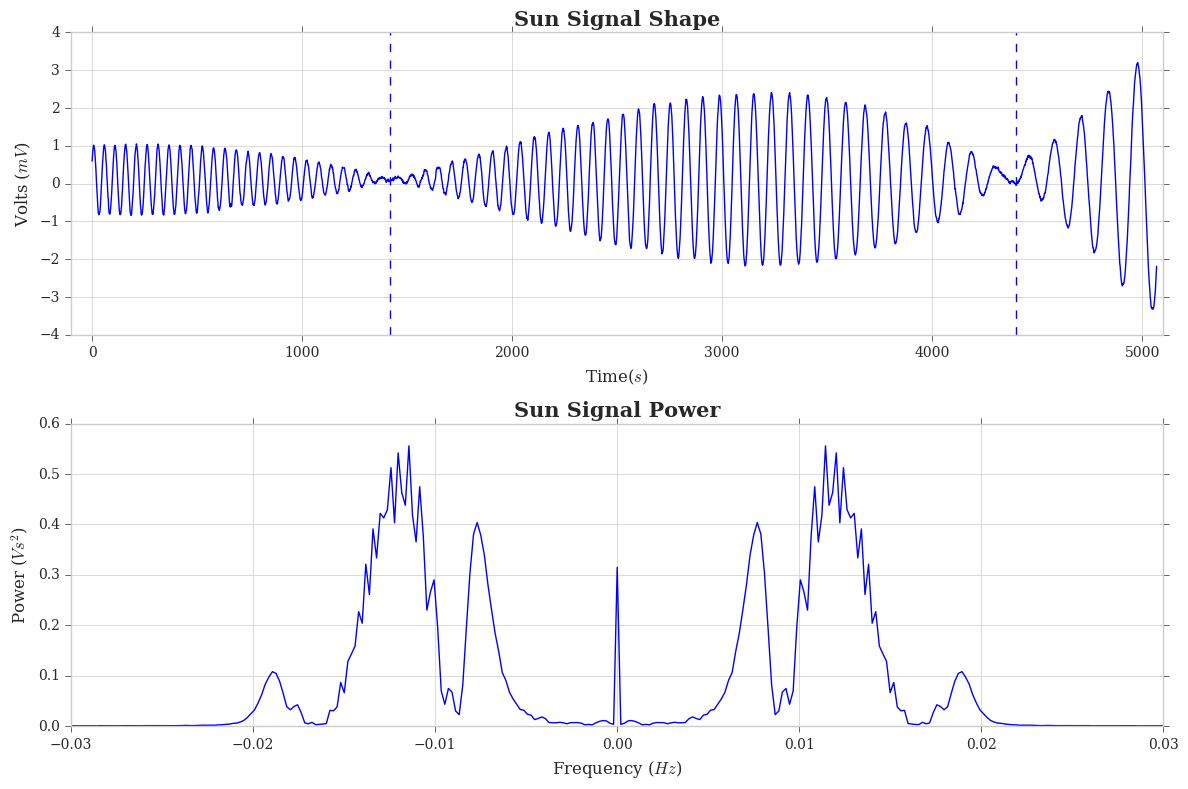

In [3]:
#PLOTTING RAW SUN DATA

data = np.load('Sun_final.npz')
sun_data = data['volts'] * 1000
freq = np.fft.fftfreq(len(sun_data), d=1)
sun_pow = np.abs(np.fft.fft(sun_data)) ** 2 / 1e6

fig, axes = plt.subplots(nrows=2,ncols=1, figsize = (12,8))

ax1 = plt.subplot(2, 1, 1)
ax1.plot(sun_data)
ax1.set_xlim(-100,5100)
ax1.set_title('Sun Signal Shape', fontweight='bold', fontsize=15)
ax1.set_ylabel('Volts ($mV$)', fontsize=12)
ax1.set_xlabel('Time($s$)', fontsize=12)
ax1.axvline(1420, linestyle='--')
ax1.axvline(4400, linestyle='--')

ax2 = plt.subplot(2, 1, 2)
ax2.plot(np.fft.fftshift(freq), np.fft.fftshift(sun_pow))
ax2.set_xlim(-0.03,0.03)
ax2.set_title('Sun Signal Power', fontweight='bold', fontsize=15)
ax2.set_ylabel('Power ($Vs^2$)', fontsize=12)
ax2.set_xlabel('Frequency ($Hz$)', fontsize=12)

fig.tight_layout()

In [4]:
#CALCULATING JD, RA, DEC, and HOUR ANGLE ARRAYS

time_data = data['times'] #in UNIX

jd_arr = []
ra_arr = []
dec_arr = []
h_arr = []

for i in time_data:
    day = julian_date(i)
    ra, dec = sunpos(day) 
    h = lst(day) - np.radians(ra) + 2*np.pi
    
    jd_arr.append(day)
    ra_arr.append(ra)
    dec_arr.append(dec) 
    h_arr.append(h)

In [5]:
#ESTABLISHING GUESSES FOR Qew

nu = 2.5 #cm
# Bew = 2000 #cm
n = 10

Qew = np.linspace(550,750,n) #guessing around 640

hs = np.mean(h_arr)
dec = np.mean(dec_arr) * np.pi / 180
print(hs, dec)

1.1469316141467278 -0.03554528978544651


In [6]:
#CALCULATING BASELINES

#Solving for A & B, Bns=0

"""
Qew = Bew/nu * cos(dec)
"""
 
def least_square(h, volts):
    
    def model(y, A, B):
        return A*np.cos(2*np.pi*y) + B*np.sin(2*np.pi*y)
    
    S_ew = []
    
    for i in range(len(Qew)):
        newy = Qew[i]*np.cos(h)
            
        params , covar = curve_fit(model, newy, volts)
        
        diff_sq = (volts - model(newy, params[0], params[1]))**2
        
        s_ew = np.sum((diff_sq))
        
        S_ew.append(s_ew)
        
    ind_ew = np.argmin(S_ew)
    Qew_best = Qew[ind_ew]
    
    return (ind_ew, Qew_best, S_ew) 

In [7]:
index1 , bestguess1, S1 = least_square(hs, sun_data)
Bew1 = (bestguess1 * nu) / ((np.cos(dec)) * 100) #to make into meters from cm
print('The East-West Baseline is approx: ', Bew1, ' meters')

The East-West Baseline is approx:  18.205944544299907  meters


In [8]:
Qns = np.linspace(15,35,n) #guessing around 24

In [9]:
#Solving for A & B, Bew = 13.606

"""
Qns = Bns/nu * cos(dec) * sin(lat)
"""

def least_square2(h, volts):
    qew = bestguess1
    
    def model(y, A, B):
        return A*np.cos(2*np.pi*y) + B*np.sin(2*np.pi*y)
    
    S_ns = []
    
    for i in range(len(Qns)):
        newy = qew*np.cos(h) + Qns[i]*np.sin(h)
            
        params , covar = curve_fit(model, newy, volts)
        
        diff_sq = (volts - model(newy, params[0], params[1]))**2
        
        s_ns = np.sum((diff_sq))
        
        S_ns.append(s_ns)
        
    ind_ns = np.argmin(S_ns)
    Qns_best = Qns[ind_ns]
    
    return (ind_ns, Qns_best, S_ns)

In [10]:
index2 , bestguess2, S2 = least_square2(hs, sun_data)

L = np.radians(37.87319)
print(bestguess2)
print(L)

Bns2 = (bestguess2 * nu) / (np.cos(dec) * np.sin(L) * 100)
print('The North-South Baseline is approx: ', Bns2, ' meters')

19.444444444444443
0.6610118637333913
The North-South Baseline is approx:  0.792320843532393  meters


In [11]:
#COMPLETE LEAST SQUARES

def lstsqr(h, volts):
    
    def model(y, A, B):
        return A*np.cos(2*np.pi*y) + B*np.sin(2*np.pi*y)
    
    S = np.zeros((n,n))
    
    qew = np.zeros((n,n))
    qns = np.zeros((n,n))
    
    perrs = []
    
    for i in range(len(Qew)):
        for j in range(len(Qns)):
            newy = Qew[i]*np.cos(h) + Qns[j]*np.sin(h)
            
            params , covar = curve_fit(model, newy, volts)
        
            diff_sq = (volts - model(newy, params[0], params[1]))**2
        
            s = np.sum((diff_sq))
        
            S[i][j] = s
            qew[i][j] = Qew[i]
            qns[i][j] = Qns[j]
            perr = np.sqrt(np.diag(covar))
            perrs.append(perr)
            
    
    return (S, qew, qns, perrs)

In [12]:
S , qew, qns, errs = lstsqr(hs, sun_data)
index = np.argmin(S)
best_qns = qns[5][4]
best_qew = qew[5][4]
print(best_qew, best_qns, bestguess1, bestguess2)

661.1111111111111 23.88888888888889 727.7777777777778 19.444444444444443


In [13]:
Bew = (best_qew * nu) / ((np.cos(dec)) * 100)
Bns = (best_qns * nu) / (np.cos(dec) * np.sin(L) * 100)
print('The East-West Baseline is approx: ', Bew, ' meters', ',', ' The North-South Baseline is approx: ', Bns, ' meters')

The East-West Baseline is approx:  16.53822443337167  meters ,  The North-South Baseline is approx:  0.9734227506255114  meters


In [14]:
baseline = np.sqrt(Bew**2 + Bns**2)
print('Full baseline =',baseline, ' meters')

Full baseline = 16.56684699211069  meters


In [15]:
#CALCULATING FRINGE AMPLITUDES AND FREQUENCY - ARRAYS THAT SHOW CHANGES IN THE FRINGE W.R.T HOUR ANGLE

def fringe_amps(hours, volts):
    
    def model(y, A, B):
        return A*np.cos(2*np.pi*y) + B*np.sin(2*np.pi*y)
    
    q1 = 661.11
    q2 = 23.88
    
    F_amps = []
    
    for i in hours:
            newy = q1*np.cos(i) + q2*np.sin(i)
            
            params , covar = curve_fit(model, newy, volts)
            
            F = model(newy, params[0], params[1])
            
            F_amps.append(F)
            
    return F_amps

In [16]:
F_amps = fringe_amps(h_arr, sun_data)
print(F_amps)

[0.11065211212634551, 0.11065083979221413, 0.1106524615379243, 0.1106517020751312, 0.11065237399628813, 0.11065170888520015, 0.11065216270171163, 0.11065335877218274, 0.11065018559779105, 0.1106524311052084, 0.1106519138031814, 0.11065196305419533, 0.11065201097414956, 0.11065156934702713, 0.11065199642416701, 0.11065418737481991, 0.11065232201488584, 0.11065220847078194, 0.1106517019660771, 0.11065111104758785, 0.11065199397117453, 0.1106506972541581, 0.11065119611056673, 0.11065174610371287, 0.11065166460539899, 0.11065194678272405, 0.11065171404334251, 0.11065084869395037, 0.11065235538315221, 0.11065439645487629, 0.11065236883072771, 0.11065385633368408, 0.11065153630099189, 0.11065082503733947, 0.11065453479484688, 0.11065125863447633, 0.11065214453385863, 0.11065237674064576, 0.11065237733993172, 0.11065236318965788, 0.11065310609455992, 0.11065252488268129, 0.11065151562809206, 0.11065146366334488, 0.1106517588170135, 0.11065079829302249, 0.11065223495103282, 0.11065212763642762

In [17]:
def fringe_freqs(hours, volts):
    '''Return a list of the local fringe frequencies.
    Parameters
    ----------
    hours : hour angle array
    volts : sampled data
    
    Returns 
    -------
    F_freqs : list of the local fringe frequencies'''
    q1 = 661.11
    q2 = 23.88
    
    F_freqs = []
    
    for i in hours:
            f = q1*np.cos(i) - q2*np.sin(i)
            
            F_freqs.append(f)
            
    return F_freqs

In [18]:
F_freqs = fringe_freqs(h_arr, sun_data)
max_f = np.max(F_freqs) * ((2*np.pi) / (3600*24))
min_f = np.min(F_freqs) * ((2*np.pi) / (3600*24))
print(max_f, min_f)

0.026044873640603945 0.009720057305102905


In [46]:
#CALCULATING THE MODULATING FUNCTION

from scipy.special import j1
from scipy.optimize import fsolve


h_zero1 = h_arr[1420]
h_zero2 = h_arr[4400]

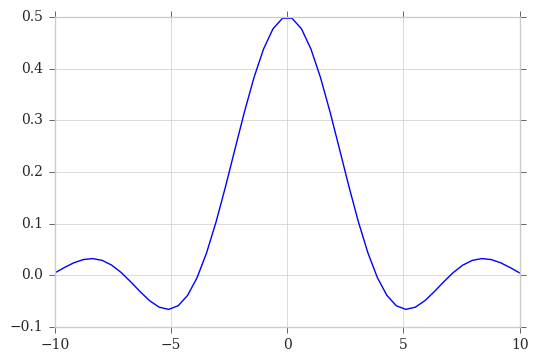

In [20]:
x = np.linspace(-10,10,50)
def fx(x):
    return j1(x)/x
roots = fsolve(fx, x)

plt.plot(x, fx(x))

In [21]:
print(roots)

[ -10.17346814  -10.17346814  -10.17346814  -10.17346814  223.83680126
   -7.01558667   -7.01558667   -7.01558667   -7.01558667   -7.01558667
   -7.01558667   -7.01558667   25.90367209   -7.01558667   -3.83170597
   -3.83170597   -3.83170597   -3.83170597   -3.83170597   -3.83170597
   -3.83170597   -3.83170597   -3.83170597   -7.01558667  -19.61585851
   19.61585851    7.01558667    3.83170597    3.83170597    3.83170597
    3.83170597    3.83170597    3.83170597    3.83170597    3.83170597
    3.83170597    7.01558667  -25.90367209    7.01558667    7.01558667
    7.01558667    7.01558667    7.01558667    7.01558667    7.01558667
 -223.83680126   10.17346814   10.17346814   10.17346814   10.17346814]


In [41]:
thetas = []

for i in roots:
    u = baseline / .025 * np.cos(h_zero1)
    theta = np.degrees(i / (2*np.pi*u))
    
    if theta > 0.3 or theta < 0.2:
        continue 
    
    thetas.append(theta)
    
theta_r = np.mean(thetas)

In [42]:
print(theta_r)

0.289416635130688


In [47]:
d = 1.496e+11
Rsun_calc = np.radians(theta_r) * d
Rsun_act = 695.51e+6

D_calc = Rsun_calc * 2
D_act = Rsun_act * 2

D_error = (D_calc - D_act) / D_act * 100

print(D_error, '%', Rsun_calc)

8.649835327142636 % 755670469.6838098


# M17 Data

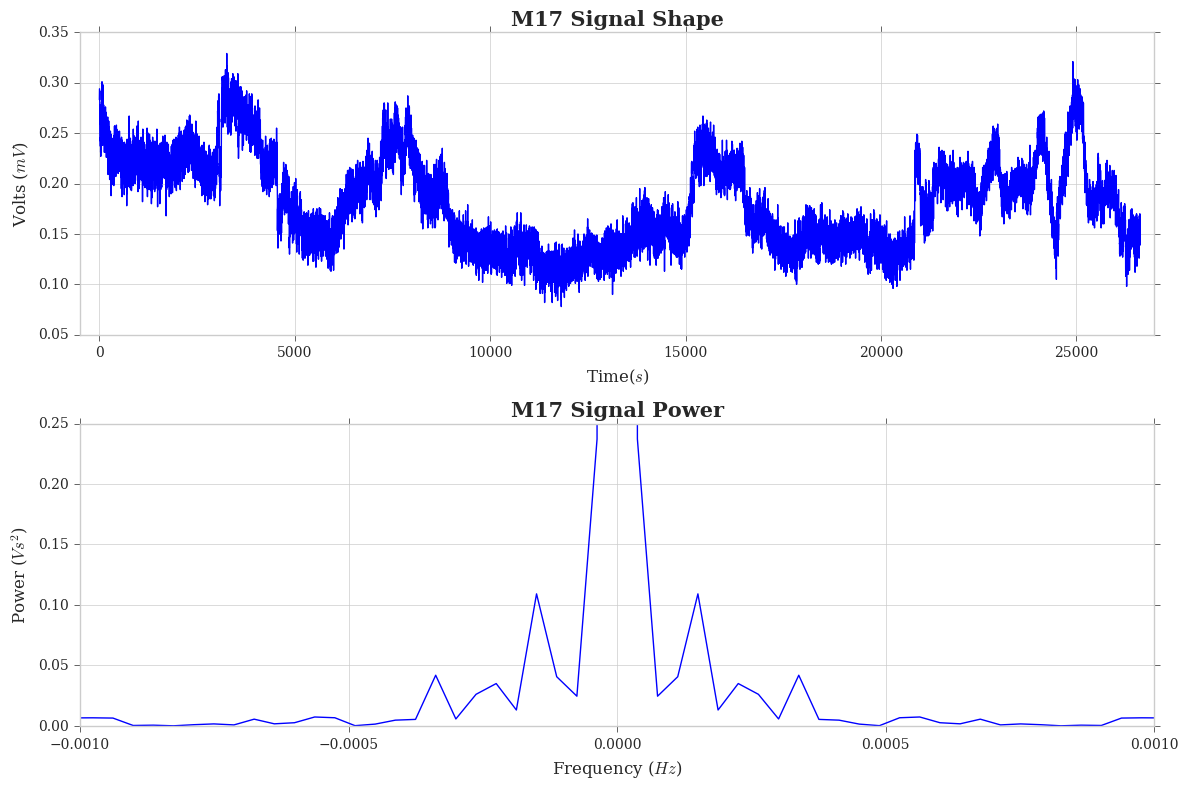

In [25]:
#PLOTTING RAW M17 DATA

data_m17 = np.load('M17_final.npz')
m17_data = data_m17['volts'] * 1000
m17_freq = np.fft.fftfreq(len(m17_data), d=1)
m17_pow = np.abs(np.fft.fft(m17_data)) ** 2 / 1e6

fig, axes = plt.subplots(nrows=2,ncols=1, figsize = (12,8))

ax3 = plt.subplot(2, 1, 1)
ax3.plot(m17_data)
ax3.set_xlim(-500,27000)
ax3.set_title('M17 Signal Shape', fontweight='bold', fontsize=15)
ax3.set_ylabel('Volts ($mV$)', fontsize=12)
ax3.set_xlabel('Time($s$)', fontsize=12)
#ax1.axvline(1420, linestyle='--')
#ax1.axvline(4400, linestyle='--')

ax4 = plt.subplot(2, 1, 2)
ax4.plot(np.fft.fftshift(m17_freq), np.fft.fftshift(m17_pow))
ax4.set_xlim(-0.001,0.001)
ax4.set_ylim(0, 0.25)
ax4.set_title('M17 Signal Power', fontweight='bold', fontsize=15)
ax4.set_ylabel('Power ($Vs^2$)', fontsize=12)
ax4.set_xlabel('Frequency ($Hz$)', fontsize=12)

fig.tight_layout()

In [26]:
time_data = data_m17['times'] #in UNIX

jd_arr2 = []
ra_arr2 = []
dec_arr2 = []
h_arr2 = []

for i in time_data:
    day = julian_date(i)
    ra, dec = precess(275.13, -16) 
    h = lst(day) - np.radians(ra) + 2*np.pi
    
    jd_arr2.append(day)
    ra_arr2.append(ra)
    dec_arr2.append(dec) 
    h_arr2.append(h)

In [27]:
hs2 = np.mean(h_arr2)
dec2 = np.mean(dec_arr2) * np.pi / 180

S2 , qew2, qns2, perrs2 = lstsqr(hs2, m17_data)
index2 = np.argmin(S2)
best_qns2 = qns[5][4]
best_qew2 = qew[5][4]

Bew2 = (best_qew2 * nu) / ((np.cos(dec2)) * 100)
Bns2 = (best_qns2 * nu) / (np.cos(dec2) * np.sin(L) * 100)
print('The East-West Baseline is approx: ', Bew2, ' meters', ',', ' The North-South Baseline is approx: ', Bns2, ' meters')

The East-West Baseline is approx:  17.193895169904135  meters ,  The North-South Baseline is approx:  1.012014850668138  meters


In [28]:
baseline2 = np.sqrt(Bew2**2 + Bns2**2)
print('Full baseline =',baseline2, ' meters')

Full baseline = 17.223652492187178  meters


In [29]:
F_amps2 = fringe_amps(h_arr2, m17_data)

F_freqs2 = fringe_freqs(h_arr2, m17_data)
max_f2 = np.max(F_freqs2) * ((2*np.pi) / (3600*24))
min_f2 = np.min(F_freqs2) * ((2*np.pi) / (3600*24))
print(max_f2, min_f2)

0.04810862964017682 0.021241934346685795


(-500, 27000)

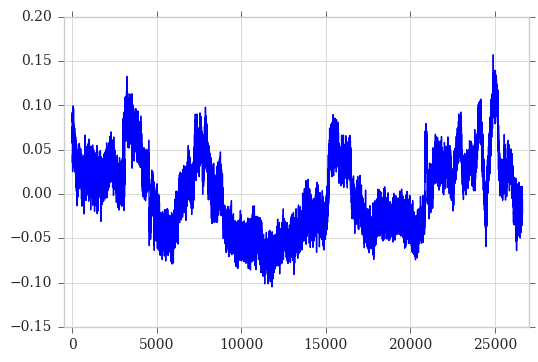

In [30]:
xs = np.linspace(1, len(m17_data), len(m17_data))
ys = m17_data
fitter = modeling.fitting.LevMarLSQFitter()
model = modeling.models.Gaussian1D()   # depending on the data you need to give some initial values
fitted_model = fitter(model, xs, ys)

new_ys = ys - fitted_model(xs)

plt.plot(new_ys)
plt.xlim(-500,27000)

# Plots

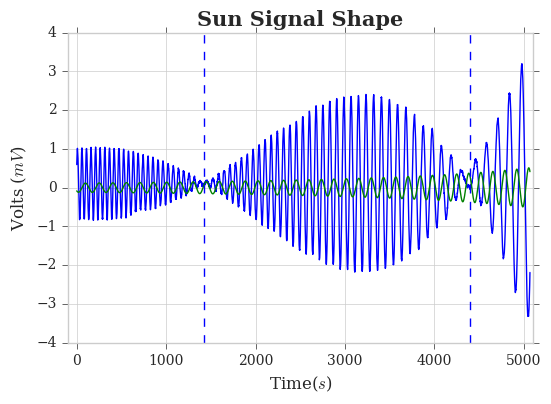

In [31]:
plt.plot(sun_data)
plt.plot(fx(F_freqs) * 1000)
plt.xlim(-100,5100)
plt.title('Sun Signal Shape', fontweight='bold', fontsize=15)
plt.ylabel('Volts ($mV$)', fontsize=12)
plt.xlabel('Time($s$)', fontsize=12)
plt.axvline(1420, linestyle='--')
plt.axvline(4400, linestyle='--')

# Errors

In [32]:
def error(data):
    
    errors = []
    
    for i in range(len(data) - 1):
        diff = data[i+1] - data[i]
        errors.append(diff)
        
    last = np.mean(errors)
    errors.append(last)
    
    return errors

In [33]:
sun_err = error(sun_data)

In [34]:
m17_err = error(m17_data)

Std: 0.07864517942592594


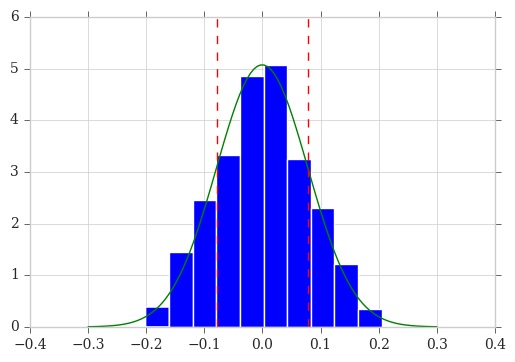

In [35]:
mean , std = norm.fit(sun_err)


xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mean, std)
plt.hist(sun_err, bins=10, normed=True)
plt.plot(x, y)
plt.axvline(-std, linestyle='--', color='red')
plt.axvline(std, linestyle='--', color='red')
print('Std:', std)

Std: 0.010657498195894758


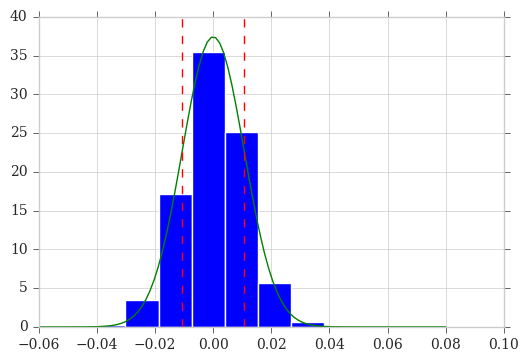

In [36]:
mean2 , std2 = norm.fit(m17_err)


xmin2, xmax2 = plt.xlim()
x2 = np.linspace(xmin2, xmax2, 100)
y2 = norm.pdf(x2, mean2, std2)
plt.hist(m17_err, bins=10, normed=True)
plt.plot(x2, y2)
plt.axvline(-std2, linestyle='--', color='red')
plt.axvline(std2, linestyle='--', color='red')
print('Std:', std2)

In [37]:
#CALCULATING S MATRIX ERRORS (Qew & Qns)

A_errs = []
B_errs = []

for i in range(len(errs)):
    cov_mat = errs[i]
    curve_mat = 1 / cov_mat
    Aerr = curve_mat[0]
    Berr = curve_mat[1]
    
    A_errs.append(Aerr)
    B_errs.append(Berr)

In [127]:
Aerrs = [x for x in A_errs if (np.isnan(x) == False)]
Berrs = [x for x in B_errs if (np.isnan(x) == False)]

full = Aerrs + Berrs
errors = np.asarray(full) - np.mean(full)
print(errors)

[-1.05399218e-07  1.05043844e-07 -2.62797816e-07  3.63872505e-07
  4.07718530e-08  2.69130119e-07 -1.15898540e-07  4.02981582e-08
  9.73319298e-08 -2.93903828e-07 -1.18840887e-07 -2.52450571e-07
 -2.72029088e-07 -1.25618646e-07 -2.85644973e-07 -2.30752974e-07
 -2.47347318e-07 -1.93388074e-07  8.13930533e-08 -2.61814461e-07
 -8.54684563e-08 -2.02304094e-07  1.57694205e-07  4.40614541e-07
  6.80638911e-07  5.12929991e-07 -1.60929312e-07 -7.59874962e-08
  2.45246654e-07  3.77691911e-07  4.13271366e-07  2.09727321e-07
 -4.73437019e-07 -2.96627265e-07 -1.69826763e-07  1.87072757e-08
  1.16935771e-07  5.66647960e-07  2.39715666e-07  1.24626729e-07
  6.99955456e-08 -3.82113930e-08  2.85241318e-07  4.76354238e-07
 -8.42795856e-09  2.33937206e-08 -9.01801316e-08  5.03666200e-08
  2.26025181e-08 -2.96276569e-07 -4.41280126e-07 -2.92840342e-07
  2.50222812e-07 -1.28133267e-07 -8.46368611e-08 -3.78201607e-07
 -2.42699898e-07 -4.51573580e-07 -1.87091572e-07 -2.64828485e-07
 -3.25854580e-07 -7.92063

Std: 2.7555121081446437e-07


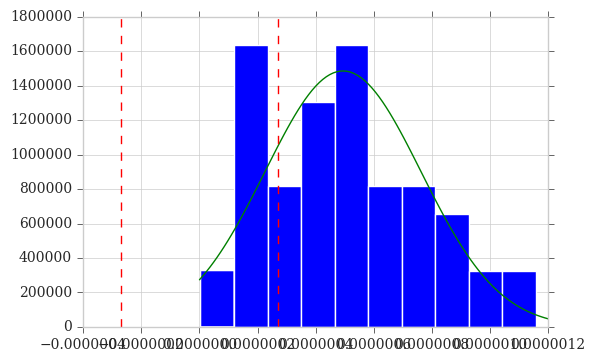

In [130]:
means , stds = norm.fit(Aerrs)

plt.hist(Aerrs, bins=10, normed=True)
xmins, xmaxs = plt.xlim()
xs = np.linspace(xmins, xmaxs, 100)
ys = norm.pdf(xs, means, stds)

plt.plot(xs, ys)
plt.axvline(-stds, linestyle='--', color='red')
plt.axvline(stds, linestyle='--', color='red')
print('Std:', std1)

In [40]:
print(Qns, Qew)

[15.         17.22222222 19.44444444 21.66666667 23.88888889 26.11111111
 28.33333333 30.55555556 32.77777778 35.        ] [550.         572.22222222 594.44444444 616.66666667 638.88888889
 661.11111111 683.33333333 705.55555556 727.77777778 750.        ]


# Graphs for Report

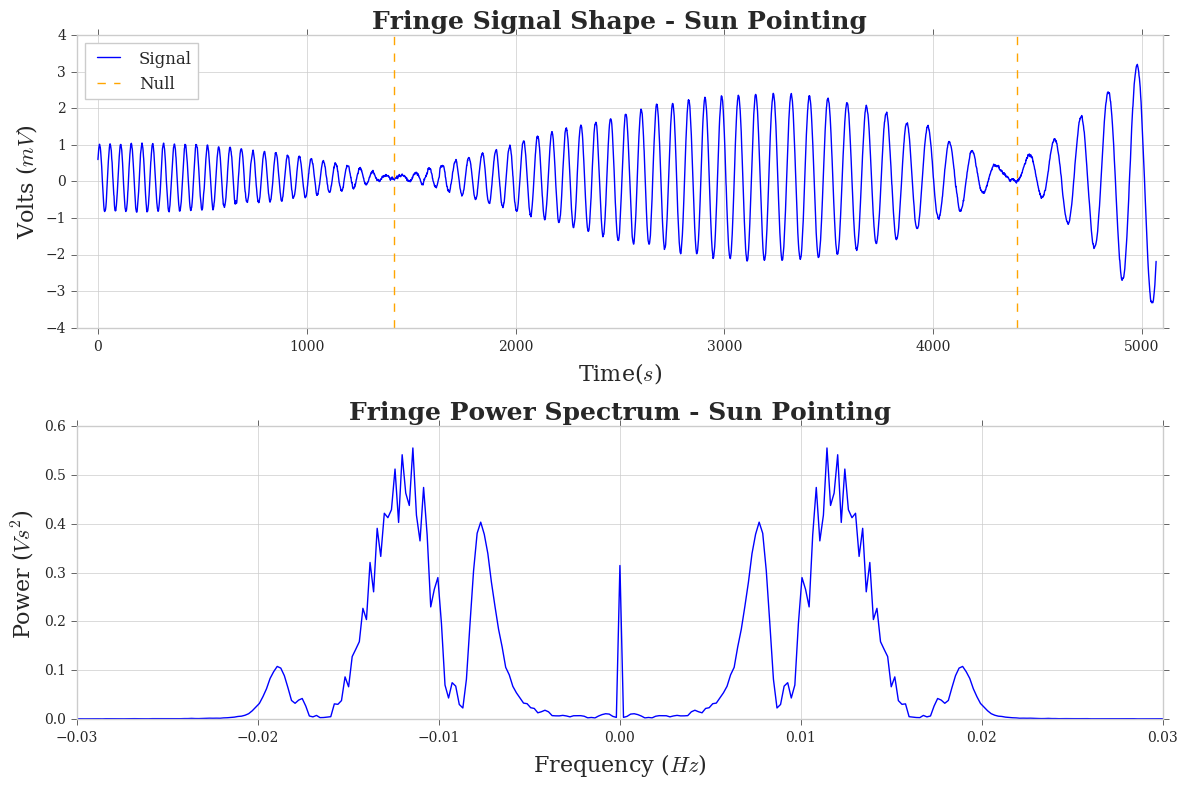

In [111]:
fig, axes = plt.subplots(nrows=2,ncols=1, figsize = (12,8))

ax1 = plt.subplot(2, 1, 1)
ax1.plot(sun_data, label='Signal')
ax1.set_xlim(-100,5100)
ax1.set_title('Fringe Signal Shape - Sun Pointing', fontweight='bold', fontsize=18)
ax1.set_ylabel('Volts ($mV$)', fontsize=16)
ax1.set_xlabel('Time($s$)', fontsize=16)
ax1.axvline(1420, linestyle='--', color='orange', label='Null')
ax1.axvline(4400, linestyle='--', color='orange')
ax1.legend(loc='best')

ax2 = plt.subplot(2, 1, 2)
ax2.plot(np.fft.fftshift(freq), np.fft.fftshift(sun_pow))
ax2.set_xlim(-0.03,0.03)
ax2.set_title('Fringe Power Spectrum - Sun Pointing', fontweight='bold', fontsize=18)
ax2.set_ylabel('Power ($Vs^2$)', fontsize=16)
ax2.set_xlabel('Frequency ($Hz$)', fontsize=16)

fig.tight_layout()

plt.savefig('sun_fringe.pdf', dpi = 1200,  transparent = True)

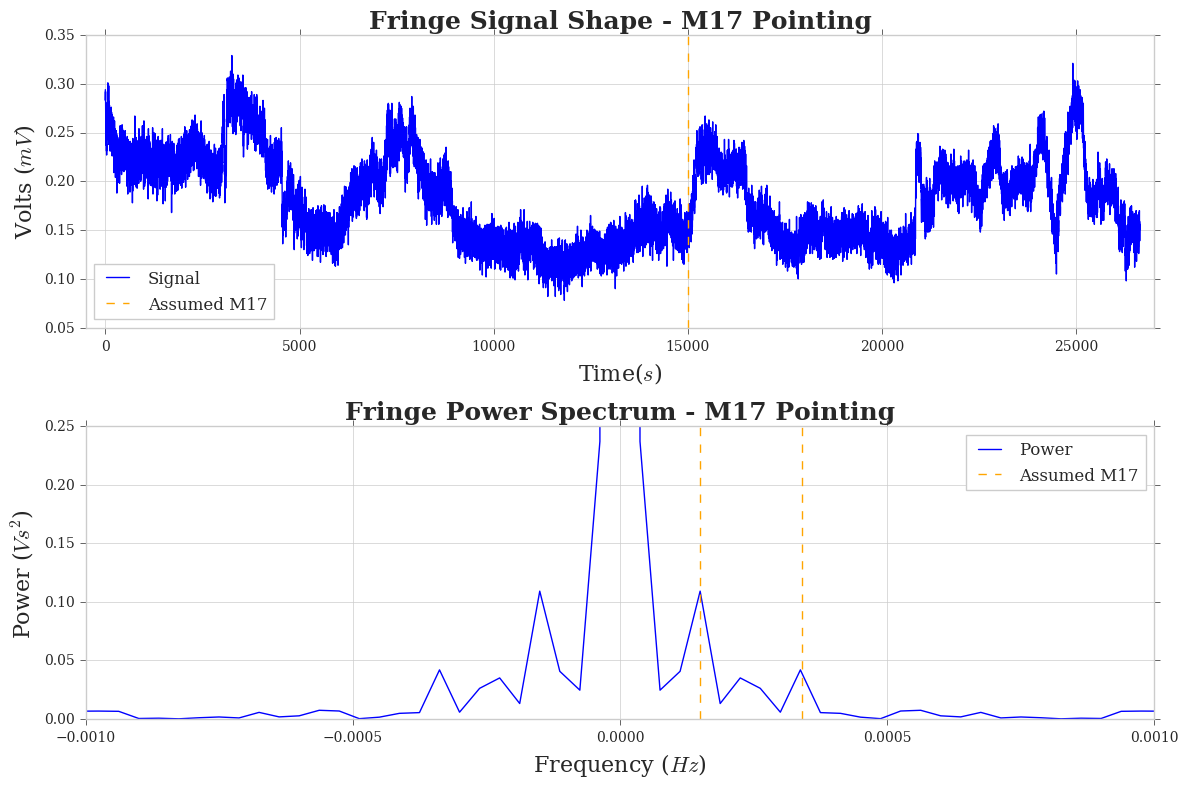

In [112]:
fig, axes = plt.subplots(nrows=2,ncols=1, figsize = (12,8))

ax3 = plt.subplot(2, 1, 1)
ax3.plot(m17_data, label='Signal')
ax3.set_xlim(-500,27000)
ax3.set_title('Fringe Signal Shape - M17 Pointing', fontweight='bold', fontsize=18)
ax3.set_ylabel('Volts ($mV$)', fontsize=16)
ax3.set_xlabel('Time($s$)', fontsize=16)
ax3.axvline(15000, linestyle='--', color='orange', label='Assumed M17')
ax3.legend(loc='best')

ax4 = plt.subplot(2, 1, 2)
ax4.plot(np.fft.fftshift(m17_freq), np.fft.fftshift(m17_pow), label='Power')
ax4.set_xlim(-0.001,0.001)
ax4.set_ylim(0, 0.25)
ax4.set_title('Fringe Power Spectrum - M17 Pointing', fontweight='bold', fontsize=18)
ax4.set_ylabel('Power ($Vs^2$)', fontsize=16)
ax4.set_xlabel('Frequency ($Hz$)', fontsize=16)
ax4.axvline(0.00015, linestyle='--', color='orange', label='Assumed M17')
ax4.axvline(0.00034, linestyle='--', color='orange')
ax4.legend(loc='best')

fig.tight_layout()

plt.savefig('m17_fringe.pdf', dpi = 1200,  transparent = True)

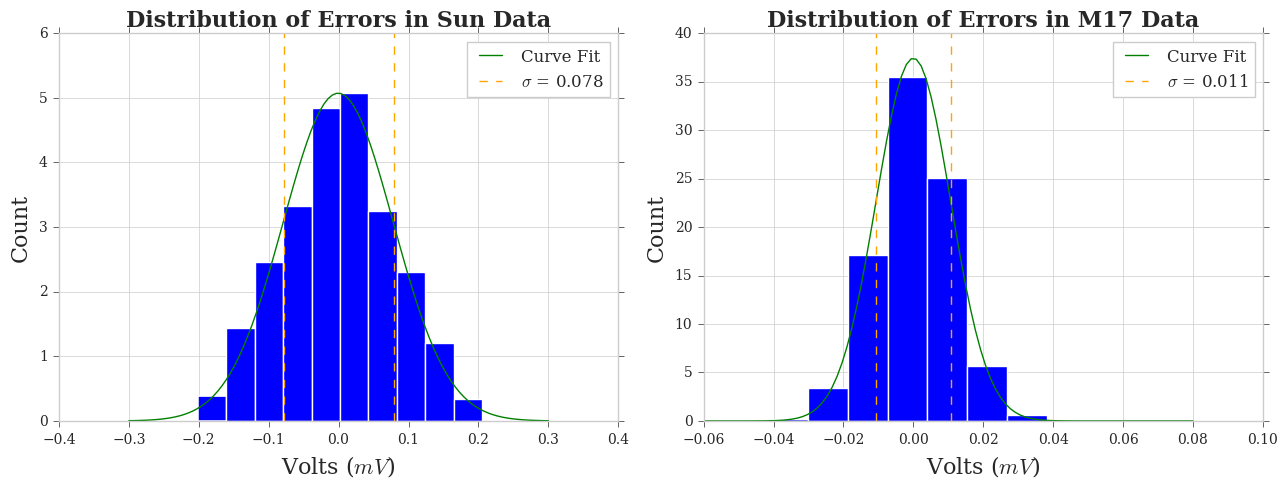

In [110]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize = (13,5))

ax1 = plt.subplot(1, 2, 1)
ax1.hist(sun_err, bins=10, normed=True)
ax1.plot(x, y, label='Curve Fit')
ax1.axvline(-std, linestyle='--', color='orange')
ax1.axvline(std, linestyle='--', color='orange', label='$\sigma$ = 0.078')
ax1.set_title('Distribution of Errors in Sun Data', fontweight='bold', fontsize=16)
ax1.set_xlabel('Volts ($mV$)', fontsize=16)
ax1.set_ylabel('Count', fontsize=16)
ax1.legend(loc='best')

ax2 = plt.subplot(1, 2, 2)
ax2.hist(m17_err, bins=10, normed=True)
ax2.plot(x2, y2, label='Curve Fit')
ax2.axvline(-std2, linestyle='--', color='orange')
ax2.axvline(std2, linestyle='--', color='orange', label='$\sigma$ = 0.011')
ax2.set_title('Distribution of Errors in M17 Data', fontweight='bold', fontsize=16)
ax2.set_xlabel('Volts ($mV$)', fontsize=16)
ax2.set_ylabel('Count', fontsize=16)
ax2.legend(loc='best')

fig.tight_layout()

plt.savefig('lab3_errors.pdf', dpi = 1200,  transparent = True)

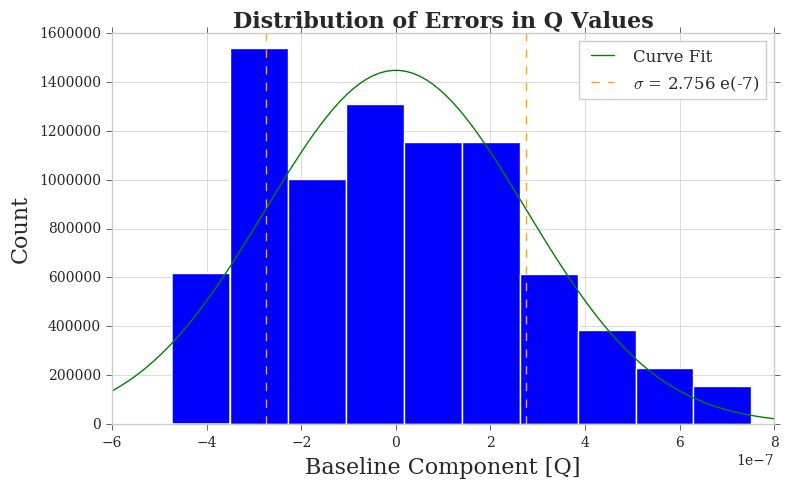

In [132]:
fig = plt.figure(figsize = (8, 5))
plt.hist(errors, bins=10, normed=True)
plt.plot(x1, y1, label='Curve Fit')
plt.axvline(-std1, linestyle='--', color='orange')
plt.axvline(std1, linestyle='--', color='orange', label='$\sigma$ = 2.756 e(-7)')
plt.title('Distribution of Errors in Q Values', fontweight='bold', fontsize=16)
plt.xlabel('Baseline Component [Q]', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.legend(loc='upper right')

fig.tight_layout()

plt.savefig('Q_errors.pdf', dpi = 1200,  transparent = True)